# Assessing the accuracy of ML-based uncertainties in the context of galaxy photometric redshifts

A data challenge for [From Quarks to Cosmos with AI](https://events.mcs.cmu.edu/qtc2021/)

_Alex I. Malz (German Centre for Cosmological Lensing)_

## Motivation: Uncertainty quantification

More and more ML/AI methods, particularly in Bayesian deep learning, yield uncertainties $\hat{p}(y | x_{i})$ of target parameters $y$ given observed random variables $x_{i}$, rather than just point estimates $\hat{y}_{i}$.
Though rarely framed as such, these uncertainties are _posteriors_, and there's more than meets the eye to what lies on the righthand side of the conditional.

Really, an estimated posterior should be writen as $p(y | x_{i}, \{y_{n}, x_{n}\}_{N}, \pi)$ for training data $\{y_{n}, x_{n}\}_{N}$ and algorithm $\pi$.
Though the dependence on training data is straightforward, the dependence on the algorithm, meaning the estimation model and its implementation, is subtle.
However, if it were not there, then every method trained on the same data would yield identical estimated uncertainties, which is not observed.
While the training set $\{y_{n}, x_{n}\}_{N}$ is equivalent to an _explicit prior_, the algorithm $\pi$ must be an _implicit prior_.

Another way of looking at estimated posteriors is in terms of the type of uncertainty encompassed by each term on the righthand side of the conditional.
For a noisy measurement or a stochastic generative process, the random variable $x_{i} \sim p(x | y_{i})$ represents the _aleatoric uncertainty_, that inherent to the data.
However, the training set $\{y_{n}, x_{n}\}_{N}$ and implemented algorithm $\pi$ could potentially be improved to yield a better estimate and thus constitute sources of _epistemic uncertainty_.
In physics, we want to learn the aleatoric uncertainty $p(x | y_{i})$, which we can't get from the $p(y | x_{i}, \{y_{n}, x_{n}\}_{N}, \pi)$ in hand without knowing $p(y | \{y_{n}, x_{n}\}_{N}, \pi)$.

Meanwhile, assessments of the performance of estimated $p(y | x_{i}, \{y_{n}, x_{n}\}_{N}, \pi)$ are almost always made by comparison to known $y_{i}$, leaving unanswered the question of how well the estimator approximates $p(y | x_{i})$.
Why?
The problem is that $p(y | x_{i})$ is not necessarily known, certainly not for observed $y_{i}$ measured in nature, but also generally for simulated $y_{i}$, at least in astrophysics.

## tl;dr Goals

This data challenge invites participants to address any of the following open problems.
- How can we use AI to estimate posteriors?
- How should we assess posterior estimates?
- How may we quantify the implicit prior(s)?

This tutorial/demo provides some starting points for answering these questions in the context of photometric redshifts (photo-$z$s).

## Context: Photometric redshifts

[Photo-$z$s](https://en.wikipedia.org/wiki/Photometric_redshift) provide an excellent testbed for addressing these issues but require some introduction.
There isn't a definitive primer, but here are several overviews that are informative, if a bit dry.
- [basic intro from Rubin Observatory](https://www.lsst.org/science/dark-energy/photometric-redshift)
- [old overview covering classic concepts](https://ned.ipac.caltech.edu/level5/Glossary/Essay_photredshifts.html)
- [recent review of estimation methods](https://arxiv.org/abs/1805.12574)
If these don't answer your questions, Chapter 0 of [my thesis](https://zenodo.org/record/3973536) might, or, better yet, [the slides from my defense](https://github.com/aimalz/ship-of-theses/tree/master/presentation) make for a better tl;dr.

One reason photo-$z$s are perfect for a data challenge is that they are simple enough to obtain $p(y | x_{i})$ along the way to generating a sample of $(y_{i}, x_{i})$ pairs.
Here, the target variable $y \to z$ is redshift, a scalar, and the data $x \to \vec{d} = (u, g, r, i, z, y)$, or some trivial function thereof, is a vector of length $<10$ observed [photometric magnitudes](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) of galaxies through [broadband optical filters](https://en.wikipedia.org/wiki/Photometric_system) (which I somewhat arbitrarily choose to be those of [the Vera C. Rubin Observatory](https://www.lsst.org/)).
Because of the extremely low dimensionality of the problem, we can forward model not just individual pairs $(z_{i}, \vec{d}_{i})$ but the entire joint probability space $p(z, \vec{d})$, thereby obtaining $p(y | x_{i})$ for every $(z_{i}, \vec{d}_{i})$.
That doesn't mean it's trivial to do so -- most of this tutorial concerns that forward-modeling procedure -- but it is possible.

Another reason photo-$z$s are perfect for this data challenge is that comprehensive uncertainty quantification for galaxy redshifts in the absence of spectroscopy are crucial for the Legacy Survey of Space and Time (LSST), an upcoming photometric survey on the Rubin Observatory.
This data challenge has the ulterior motive of strengthening the cosmology analysis pipeline of LSST's Dark Energy Science Collaboration (DESC).
This tutorial makes use of two pieces of software DESC members are publicly developing right now, [RAIL](https://github.com/LSSTDESC/RAIL) and [qp](https://github.com/LSSTDESC/qp), whose functionality will be introduced where relevant, along with other code dependencies.
Participants need not use either in their responses to the challenge questions, but the development team welcomes feedback from potential users, contributions to the codebase that could result from this data challenge, and new team members, DESC membership not required.

# Tutorial and challenge prompts

Finally, without more ado, we set the stage with a tutorial that:
1. creates realistically complex mock photo-$z$ posteriors, redshifts, and photometry to define training and test sets;
2. estimates photo-$z$ posteriors of the test set given the training set using ML;
3. quantifies how closely the estimated posteriors approximate the true ones.

_The three-pronged structure of this tutorial is inspired by that of RAIL, which has subpackages corresponding to each of the enumerated parts of the tutorial: `rail.creation`, `rail.estimation`, and `rail.evaluation`._

The challenge comes from building on the tutorial content to conduct a self-guided investigation of the open questions.
To get the most out of this opportunity, think of this tutorial as a lab manual that presents an experimental procedure to answer each question and includes an example of a possible solution, then invites participants to "riff" on those solutions to devise and implement their own.
The greatest opportunities for such investigations can be found under the headings **"Your turn!"** throughout the tutorial, but there are certainly more interesting directions to go in.

## 0. Setup

This tutorial uses several packages that may not be installed in the conference's kernel.
The following commands installed them successfully on Google Colab, but there might be a better way to install it on PSC machines.
On the PSC machines, first follow [these instructions](https://gist.github.com/EiffL/a8cfa39c635334d063f0d3c07a85d1ec).

In [7]:
#!pip install cde-diagnostics
#!pip install cdetools
#!pip install corner
#!pip install FlexCode
#!pip install pzflow
#!pip install sklearn
#!pip install xgboost==0.90

In [1]:
#import jax.numpy as jnp
import numpy as np
import pandas as pd
import sklearn

In [9]:
#!git clone https://github.com/COINtoolbox/photoz_catalogues.git ..
!pip install git+https://github.com/LSSTDESC/RAIL.git#egg=rail[Full]
!pip install git+https://github.com/LSSTDESC/qp.git#egg=qp[Full]

  Cloning https://github.com/LSSTDESC/RAIL.git to c:\users\dzhao\appdata\local\temp\pip-install-fbl2ssal\rail
  Cloning https://github.com/LSSTDESC/DESC_BPZ to c:\users\dzhao\appdata\local\temp\pip-install-fbl2ssal\desc-bpz
  Using cached pzflow-1.7.0.tar.gz (7.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


ERROR: Could not find a version that satisfies the requirement jaxlib (from pzflow->rail[Full]) (from versions: none)
ERROR: No matching distribution found for jaxlib (from pzflow->rail[Full])


  Cloning https://github.com/LSSTDESC/qp.git to c:\users\dzhao\appdata\local\temp\pip-install-rzb0h_m3\qp
  Created wheel for qp: filename=qp-0.2+beta.148.g44e3-py3-none-any.whl size=73881 sha256=056eea04ead8fcfaefdf4370c78e9440c894db93d4e452c1280dd6d66c010e8d
  Stored in directory: C:\Users\dzhao\AppData\Local\Temp\pip-ephem-wheel-cache-ir617wyb\wheels\a5\d0\99\1541918b2e3b778690fa82e590fc8b338ae11120230fc68e78
Successfully built qp


  Cloning https://github.com/LSSTDESC/RAIL.git to c:\users\dzhao\appdata\local\temp\pip-install-tlk0tgxz\rail
  Cloning https://github.com/LSSTDESC/DESC_BPZ to c:\users\dzhao\appdata\local\temp\pip-install-tlk0tgxz\desc-bpz
  Using cached pzflow-1.7.0.tar.gz (7.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


ERROR: Could not find a version that satisfies the requirement jaxlib (from pzflow->rail[Full]) (from versions: none)
ERROR: No matching distribution found for jaxlib (from pzflow->rail[Full])


In [2]:
import cdetools
import flexcode
import pzflow
import qp
import rail

Found classifier BPZ_lite
Found classifier FZBoost
Found classifier simpleNN
Found classifier trainZ
Found classifier randomPZ


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
mpl.rc('text', usetex=False)

import corner

## 1. Generating test and training data, including true photo-$z$ posteriors

This is the most complex of the parts of the tutorial, which should leave readers with a sense of why this kind of experiment has not been done for higher-dimensional data.
There are three main steps:
0. Prepare and explore data to use as the basis for a realistically complex generative model.
1. Emulate a realistically complex $p(z, \vec{d})$ probability space using input data.
2. Emulate a distinct $p'(z, \vec{d})$ probability space from an existing model $p(z, \vec{d})$ of that space.
3. Sample $p(z, \vec{d})$ and $p'(z, \vec{d})$ to produce test and training sets, respectively, with known $z$, $\vec{d}$, and $p(z | \vec{d})$.

### Data

Though we're going to forward-model mock data to experiment on, we want it to be _realistically complex_, meaning it shares the physical degeneracies and systematic errors that would be present in a real data set.
The [Happy/Teddy data sets](https://github.com/COINtoolbox/photoz_catalogues) (see [Beck, et al 2017](https://arxiv.org/abs/1701.08748) for full release notes) are curated subsamples of the [Sloan Digital Sky Survey (SDSS) Data Release (DR) 12](https://www.sdss.org/dr12/), a spectroscopic survey with high-fidelity redshift measurements, and were created by the [Cosmostatistics Initiative (COIN)](https://cosmostatistics-initiative.org/).
The data sets are defined to emulate the kinds of differences in observational properties of galaxies with measured spectroscopic redshifts and those for which only photometry is available, and they were created with the goal of determining the impact of imbalance between training, validation, and test sets for photo-$z$ point estimation.
They are thus an appropriate starting point for creating a realistically complex model of the joint probability space $p(z, \vec{d})$.

Of course there are plenty of other potential data sets available, including those that are simulated, which may be advantageous for the potential to estimate other galaxy properties such as stellar mass and star formation rate that are known in a simulation but not directly measurable with real data.

In [ ]:
happy_path = '../photoz_catalogues/Happy/happy_'
header = pd.read_csv(happy_path+'A', delim_whitespace=True, nrows=0).columns[1:]
teddy_path = '../photoz_catalogues/Teddy/teddy_'

happy, teddy = {}, {}
for lett in ['A', 'B', 'C', 'D']:
    happy[lett] = pd.read_csv(happy_path+lett, delim_whitespace=True, header=None, skiprows=1, names=header)
    happy[lett] = happy[lett]
    teddy[lett] = pd.read_csv(teddy_path+lett, delim_whitespace=True, header=None, skiprows=7, names=header)
    teddy[lett] = teddy[lett]

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for j, col in enumerate(['z_spec', 'mag_r']):
    for i, lett in enumerate(['A', 'B', 'C', 'D']):
        ax[j][0].hist(happy[lett][col], alpha=0.25, bins=100, density=False, label='happy_'+lett)
        ax[j][1].hist(teddy[lett][col], alpha=0.25, bins=100, density=False, label='teddy_'+lett)
        ax[j][0].set_xlabel(col)
        ax[j][0].legend()
        ax[j][1].set_xlabel(col)
        ax[j][1].legend()

For convenience later on, we can safely cut off the tiny fraction of outliers in redshift and $r$-band magnitude.

In [4]:
z_min, z_max = 0., 1.5
r_min, r_max = 10., 25.

In [ ]:
colorcycle = 'rbgcmy'
fig = corner.corner(happy['A'][['u-g', 'g-r', 'r-i', 'i-z']], color='k', alpha=0.25)
for i, lett in enumerate(['B', 'C', 'D']):
    corner.corner(happy[lett][['u-g', 'g-r', 'r-i', 'i-z']], fig=fig, color=colorcycle[i], alpha=0.25)
    
fig = corner.corner(teddy['A'][['u-g', 'g-r', 'r-i', 'i-z']], color='k', alpha=0.25)
for i, lett in enumerate(['B', 'C', 'D']):
    corner.corner(teddy[lett][['u-g', 'g-r', 'r-i', 'i-z']], fig=fig, color=colorcycle[i], alpha=0.25)

### Emulating $p(z, \vec{d})$ from input data with `pzflow`

[`pzflow`](https://github.com/jfcrenshaw/pzflow) is a package for making normalizing flows from sets of redshifts and photometry in order to estimate or otherwise model photo-$z$ posteriors.
We'll use it to make a normalizing flow that will serve as the model for $p(z, \vec{d})$.
This is the only part of the tutorial that explicitly takes advantage of GPU capabilities.

_This content is adapted from pzflow's [conditional redshifts demo](https://github.com/jfcrenshaw/pzflow/blob/main/examples/conditional_redshift_example.ipynb), written by John Franklin Crenshaw (UW)._
_The same functionality can also be accessed through a `rail.Creator()` object._

In [5]:
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data

Let's start with a demonstration of how pzflow makes a model of $p(z, \vec{d})$ from its own demo data.

In [7]:
data = galaxy_data()

# restrict to Happy/Teddy range for coverage in demo
data = data[(data['redshift'] > z_min) & (data['redshift'] < z_max) & (data['r'] > r_min) & (data['r'] < r_max)]

# normalize
data = data.values

# use fewer bands to be able to compare with Happy/Teddy
data = data[:, :-1]

# convert magnitudes to a reference magnitude and colors
data[:, 1], data[:, 2:] = data[:, 3], np.diff(data[:,1:])

# standard scale the reference magnitude and colors
data[:, 1:] = (data[:, 1:] - data[:, 1:].mean(axis=0))/data[:, 1:].std(axis=0)

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
means = data[:, 1:].mean(axis=1)
stds = data[:, 1:].std(axis=1)

# save the new set
data = pd.DataFrame(data, columns=('redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'))
# trim_data[i][lett] = data

Training 125 epochs 
Loss:
(0) 1.8870
(1) -0.3104
(7) -1.9944
(13) -2.0265
(19) -2.3734
(25) -2.4139
(31) -2.5211
(37) -2.5587
(43) -2.5231
(49) -2.4128
(55) -2.5569
(61) -2.6418
(67) -2.2866
(73) -2.7159
(79) -2.7633
(85) -2.8358
(91) -2.5300
(97) -2.8768
(103) -2.7201
(109) -2.7230
(115) -2.8499
(121) -2.9356


(125) -2.9544


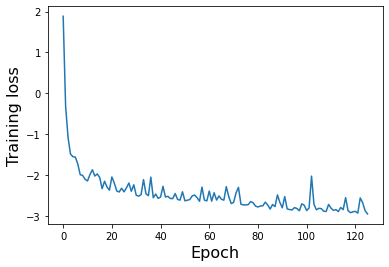

In [8]:
# set the inverse softplus parameters, estimated
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 5
n_epoch = 125

# construct our bijector
# by chaining all these layers
bijector = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means[column_idx], stds[column_idx]),
    RollingSplineCoupling(nlayers=1, n_conditions=len(data.columns)-1),
)

# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(data.columns[:1], bijector, conditional_columns=data.columns[1:])

losses = flow.train(data, epochs=n_epoch, verbose=True)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

We need to choose a redshift grid upon which to evaluate the posterior PDFs.

In [7]:
granularity = 100
grid = np.linspace(z_min, z_max, granularity)

Let's check one of them before making more.

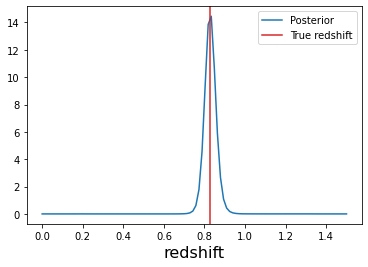

In [10]:
chosen = 999

galaxy = data.loc[[chosen]]
pdf = flow.posterior(galaxy, column="redshift", grid=grid)

plt.plot(grid, pdf[0], label='Posterior')
plt.axvline(galaxy['redshift'].values[0], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

The code below limits the number of sample posteriors to generate only because I ran out of memory when attempting to save posteriors for the whole set of demo data on PSC (but not on Google Colab).

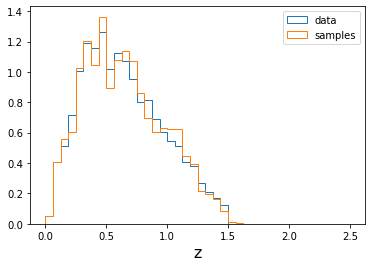

In [11]:
samples = flow.sample(1, conditions=data[:5000], seed=0)
plt.hist(data['redshift'], range=(0, 2.5), bins=40, histtype='step', label='data', density=True)
plt.hist(samples['redshift'], range=(0, 2.5), bins=40, histtype='step', label='samples', density=True)
plt.xlabel('z')
plt.legend()
plt.show()

In [13]:
z = samples['redshift']
z.to_csv('test_set_redshifts.csv')

phot = samples[['r', 'u-g', 'g-r', 'r-i', 'i-z']]
phot.to_csv('test_set_photometry.csv')

posteriors = flow.posterior(samples, column="redshift", grid=grid)
with open('test_set_posteriors.csv', 'wb') as fn:
    jnp.save(fn, posteriors)

We can do this procedure for all the Happy/Teddy samples so we can experiment with them later.
It's kind of slow, at least without using GPU, and it only needs to be done once, so we won't do it in realtime.

In [ ]:
# full_data = {'happy': happy, 'teddy': teddy}
# n_out = 1000

# for name, dat in full_data.items():
#     for lett in ['A', 'B', 'C', 'D']:
#         print(name+lett)
#         print(dat[lett].columns)
#         dat[lett] = dat[lett][['z_spec', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z']]
#         dat[lett] = dat[lett][(dat[lett]['z_spec'] > z_min) & (dat[lett]['z_spec'] < z_max) & (dat[lett]['mag_r'] > r_min) & (dat[lett]['mag_r'] < r_max)]
#         dat[lett] = dat[lett].rename(columns={'z_spec': 'redshift', 'mag_r': 'r'})
  
#         data = dat[lett].values

#     # standard scale the reference magnitude and colors
#         data[:, 1:] = (data[:, 1:] - data[:, 1:].mean(axis=0))/data[:, 1:].std(axis=0)

#     # calculate the mean and standard deviations of thefrom sklearn.cross_validation import train_test_split dimensions
#     # note that on this side of the color transform, we are working
#     # in color space, so I calculate the mean and std dev of these 
#     # variables instead of the raw magnitudes
#         means = data[:, 1:].mean(axis=0)
#         stds = data[:, 1:].std(axis=0)

#     # save the new set
#         data = pd.DataFrame(data, columns=('redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'))

#     # construct our bijector
#   # by chaining all these layers
#         bijector = Chain(
#           InvSoftplus(column_idx, sharpness),
#           StandardScaler(means[column_idx], stds[column_idx]),
#           RollingSplineCoupling(nlayers=1, n_conditions=len(data.columns)-1),
#         )

#   # To create the conditional flow, we have to provide
#   # 1. The names of the data columns
#   # 2. The bijector
#   # 3. The names of the conditional columns
#         flow = Flow(data.columns[:1], bijector, conditional_columns=data.columns[1:])

#         losses = flow.train(data, epochs=n_epoch, verbose=False)

#         samples = flow.sample(1, conditions=data.sample(n_out), seed=0)

#         z = samples['redshift']
#         z.to_csv(name+lett+'redshifts.csv', index=False)

#         phot = samples[['r', 'u-g', 'g-r', 'r-i', 'i-z']]
#         phot.to_csv(name+lett+'photometry.csv', index=False)

#         posteriors = flow.posterior(samples, column="redshift", grid=grid)
#         with open(name+lett+'posteriors.csv', 'wb') as fn:
#             jnp.save(fn, posteriors)

### Emulating $p'(z, \vec{d})$ from $p(z, \vec{d})$ using `rail.creation`

While one can build $p(z, \vec{d})$ from an input data set, more systematic investigation can be conducted by creating many training, validation, and test set combinations that are incremental variations on one another.
As one of RAIL's purposes is to conduct one such experiment, the `rail.creation` subpackage not only wraps `pzflow` (the above example can be executed just as easily through the RAIL interface) but also includes physically motivated forms of systematic discrepancy between training and test sets that can be applied to a tunable degree to create "degraded" versions of an original $p(z, \vec{d})$ space.
So, for completeness, let's demonstrate how to create a new $p'(z, \vec{d})$ from an existing $p'(z, \vec{d})$ using `rail.creation`.

_This content is taken directly from RAIL's [degradation demo](), written by John Franklin Crenshaw (UW)._

In [14]:
from pzflow.examples import example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion

We can create a new normalizing flow model of the $p(z, \vec{d})$ space based on an existing one.
Let's start with one that emulates redshift incompleteness.

In [15]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=InvRedshiftIncompleteness(0.8))

In [16]:
samples = creator.sample(100000)
degraded_samples = degraded_creator.sample(100000)

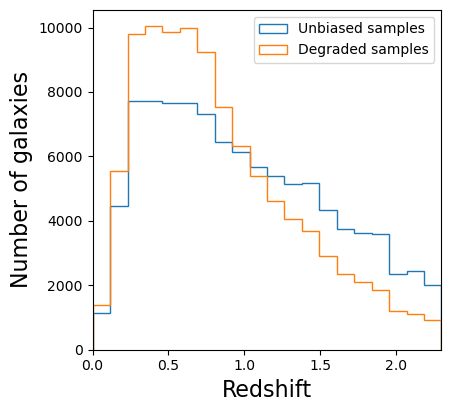

In [17]:
fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.hist(samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Unbiased samples")
ax.hist(degraded_samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Degraded samples")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,2.3))
plt.show()

As expected, the "degraded" model has a different redshift distribution than the original one.
Next, we can try to emulate errors in the spectroscopic catalog that can arise from misidentified emission lines.

In [18]:
def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)
    return data

In [19]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=OxygenLineConfusion)

In [20]:
samples = creator.sample(100000, seed=0)
degraded_samples = degraded_creator.sample(100000, seed=0)

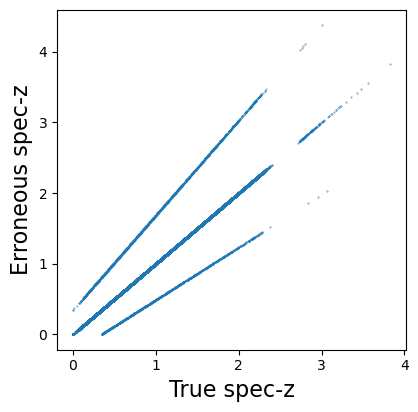

In [21]:
fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.scatter(samples["redshift"], degraded_samples["redshift"], s=0.1)
ax.set(xlabel="True spec-z", ylabel="Erroneous spec-z")
plt.show()

### Your turn!

These are just two ways to create a probability space $p(z, \vec{d})$ that can forward model redshifts, photometry, and photo-$z$ posteriors.
Next, we'll use the samples drawn from these systematically different models as training, validation, and test sets for estimators of photo-$z$ posteriors.

**CHALLENGE**: Try modeling $p(z, \vec{d})$ with different starting data sets.

**CHALLENGE**: How would you incorporate the notion of measurement errors ($\vec{d}_{meas} \sim p(\vec{d}_{meas} | \vec{d}_{true})$) into the normalizing flow model for the data?

**CHALLENGE**: Make systematically different sample data sets to use as training, validation, and test sets, varying them in controlled ways.

**CHALLENGE**: Devise and implement another creator of a joint probability space that can encompass realistic complexity of photometric data.

**CHALLENGE**: Extend the probability space to $p(z, SED)$ to draw redshifts, full spectra, and redshift posteriors.

## 2. Estimating photo-z posterior PDFs

There are many estimators of photo-$z$ posteriors, and many of those are compared to one another in [Schmidt & Malz, et al. 2020](https://arxiv.org/abs/2001.03621). 
Of the tested estimators, including ML and non-ML methods, the most promising was [`FlexCode`](https://github.com/tpospisi/FlexCode) ([Izbicki & Lee, 2017](https://arxiv.org/abs/1704.08095)), which also happens to be one of the easiest to install and apply, so we'll demonstrate it as an example of an estimator of photo-$z$ posteriors.

### Estimating photo-$z$ posterior PDFs with FlexCode

A demonstration of `FlexCode` in the context of photo-$z$s can be found in [Dalmasso, et al 2019](https://arxiv.org/abs/1908.11523), with demos in `R` published on [GitHub](https://github.com/Mr8ND/cdetools_applications).
We'll demonstrate it on the pzflow-based samples generated from the Happy/Teddy data sets.
**TODO: save the outputs for convenience**

_This content is adapted from FlexCode's [Teddy tutorial](https://github.com/tpospisi/FlexCode/blob/master/tutorial/Flexcode-tutorial-teddy.ipynb), written by Nic Dalmasso (CMU)._
_The same functionality can also be accessed through a `rail.Estimator()` object; see [tutorial](https://github.com/LSSTDESC/RAIL/blob/master/examples/estimation/RAIL_estimation_demo.ipynb) written by Sam Schmidt (UC Davis)._

In [8]:
n_grid = granularity

# Parameters
basis_system = "cosine"  # Basis system
max_basis = 31           # Maximum number of basis. If the model is not tuned,
                         # max_basis is set as number of basis

Let's try first with a representative training/validation set.

In [20]:
# original input data from alex's tutorial

# x_orig = pd.read_csv('test_set_photometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
# y_orig = pd.read_csv('test_set_redshifts.csv')[['redshift']].to_numpy()
# posteriors_orig = pd.DataFrame(np.load('test_set_posteriors.csv')).to_numpy()

# # n_samp = 10000
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test, posteriors_train, posteriors_test = train_test_split(x_orig, y_orig, posteriors_orig, 
#                                                                                        train_size=2000, random_state=42)
# x_train, x_validation, y_train, y_validation, posteriors_train, posteriors_validation = train_test_split(x_train, y_train, posteriors_train, 
#                                                                                                          train_size=1000, random_state=42)

In [10]:
# data generated via teddy data
BASE_PATH = '/ocean/projects/cis210053p/shared/new_teddy_A_and_B/'

# train/validation data
x_train_val = pd.read_csv(BASE_PATH + '/teddyAphotometry_NEW.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y_train_val = pd.read_csv(BASE_PATH + '/teddyAredshifts_NEW.csv')[['redshift']].to_numpy()
posteriors_train_val = pd.DataFrame(np.load(BASE_PATH + 'teddyAposteriors_NEW.csv')).to_numpy()

# test
x_test = pd.read_csv(BASE_PATH + '/teddyBphotometry_NEW.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y_test = pd.read_csv(BASE_PATH + '/teddyBredshifts_NEW.csv')[['redshift']].to_numpy()
posteriors_test = pd.DataFrame(np.load(BASE_PATH + 'teddyBposteriors_NEW.csv')).to_numpy()

# split the train_val into train and validation
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation, posteriors_train, posteriors_validation = train_test_split(
    x_train_val, y_train_val, posteriors_train_val, train_size=int(0.75 * x_train_val.shape[0]), random_state=42
)

In [11]:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(55731, 5)
(18578, 5)
(55731, 1)
(18578, 1)


#### Nearest Neighbors

In [21]:
# Select regression method
from flexcode.regression_models import NN

# Regression Parameters 
# If a list is passed for any parameter automatic 5-fold CV is used to
# determine the best parameter combination.
params = {"k": 5}#[5, 10, 15, 20]}       # A dictionary with method-specific regression parameters.

# Parameterize model
model = flexcode.FlexCodeModel(NN, max_basis, basis_system, regression_params=params)

# Fit model - this will also choose the optimal number of neighbors `k`
model.fit(x_train, y_train)

# Tune model - Select the best number of basis
model.tune(x_validation, y_validation)

# Predict new densities on grid
cde_test, y_grid = model.predict(x_test, n_grid=n_grid)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_s

#### XGBoost

In [12]:
import xgboost as xgb
# from flexcode import regression_models
from flexcode.regression_models import XGBoost  #, CustomModel
from cdetools.cde_loss import cde_loss

In [13]:
# Parameterize model
model = flexcode.FlexCodeModel(
    XGBoost, max_basis=31, basis_system="cosine",
    regression_params={'max_depth': 3, 'learning_rate': 0.5, 'objective': 'reg:linear'}, 
)

# Fit and tune model
model.fit(x_train, y_train)
cdes_predict_xgb, y_grid = model.predict(x_test, n_grid=1000)

/jet/home/mcstanle/.local/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [14]:
cde_loss_val, std_cde_loss = cde_loss(cdes_predict_xgb, y_grid, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -9.67 \pm 0.02


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


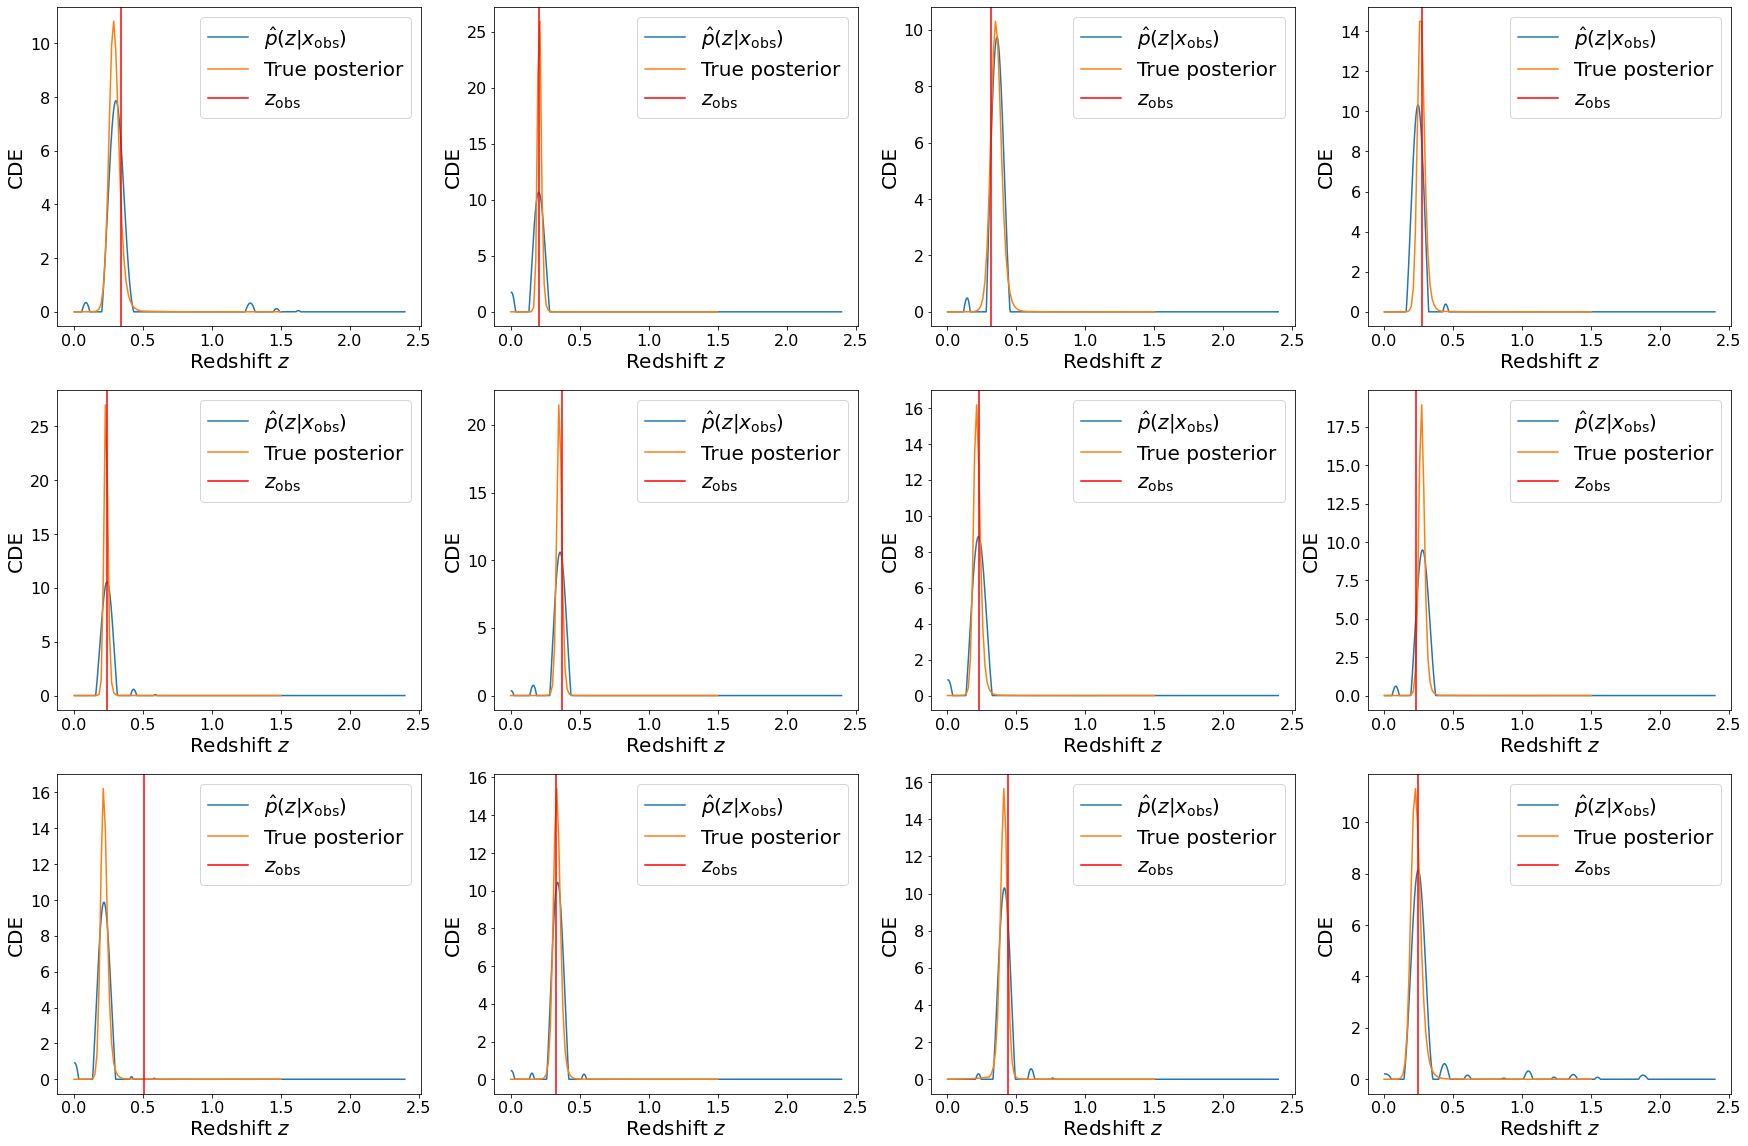

In [15]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cdes_predict_xgb[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(y_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.plot(grid, posteriors_test[jj], label='True posterior')
    plt.axvline(y_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

##### Bump Removal

In [16]:
threshold_vec = [5e-2, 1e-1, 5e-1]
model.tune(x_validation, y_validation, bump_threshold_grid=threshold_vec, n_grid=n_grid)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)

Best Bump Removal Threshold: 0.05


In [17]:
cdes_predict_xgb, y_grid = model.predict(x_test, n_grid=1000)

In [ ]:
cde_loss_val, std_cde_loss = cde_loss(cdes_predict_xgb, y_grid, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

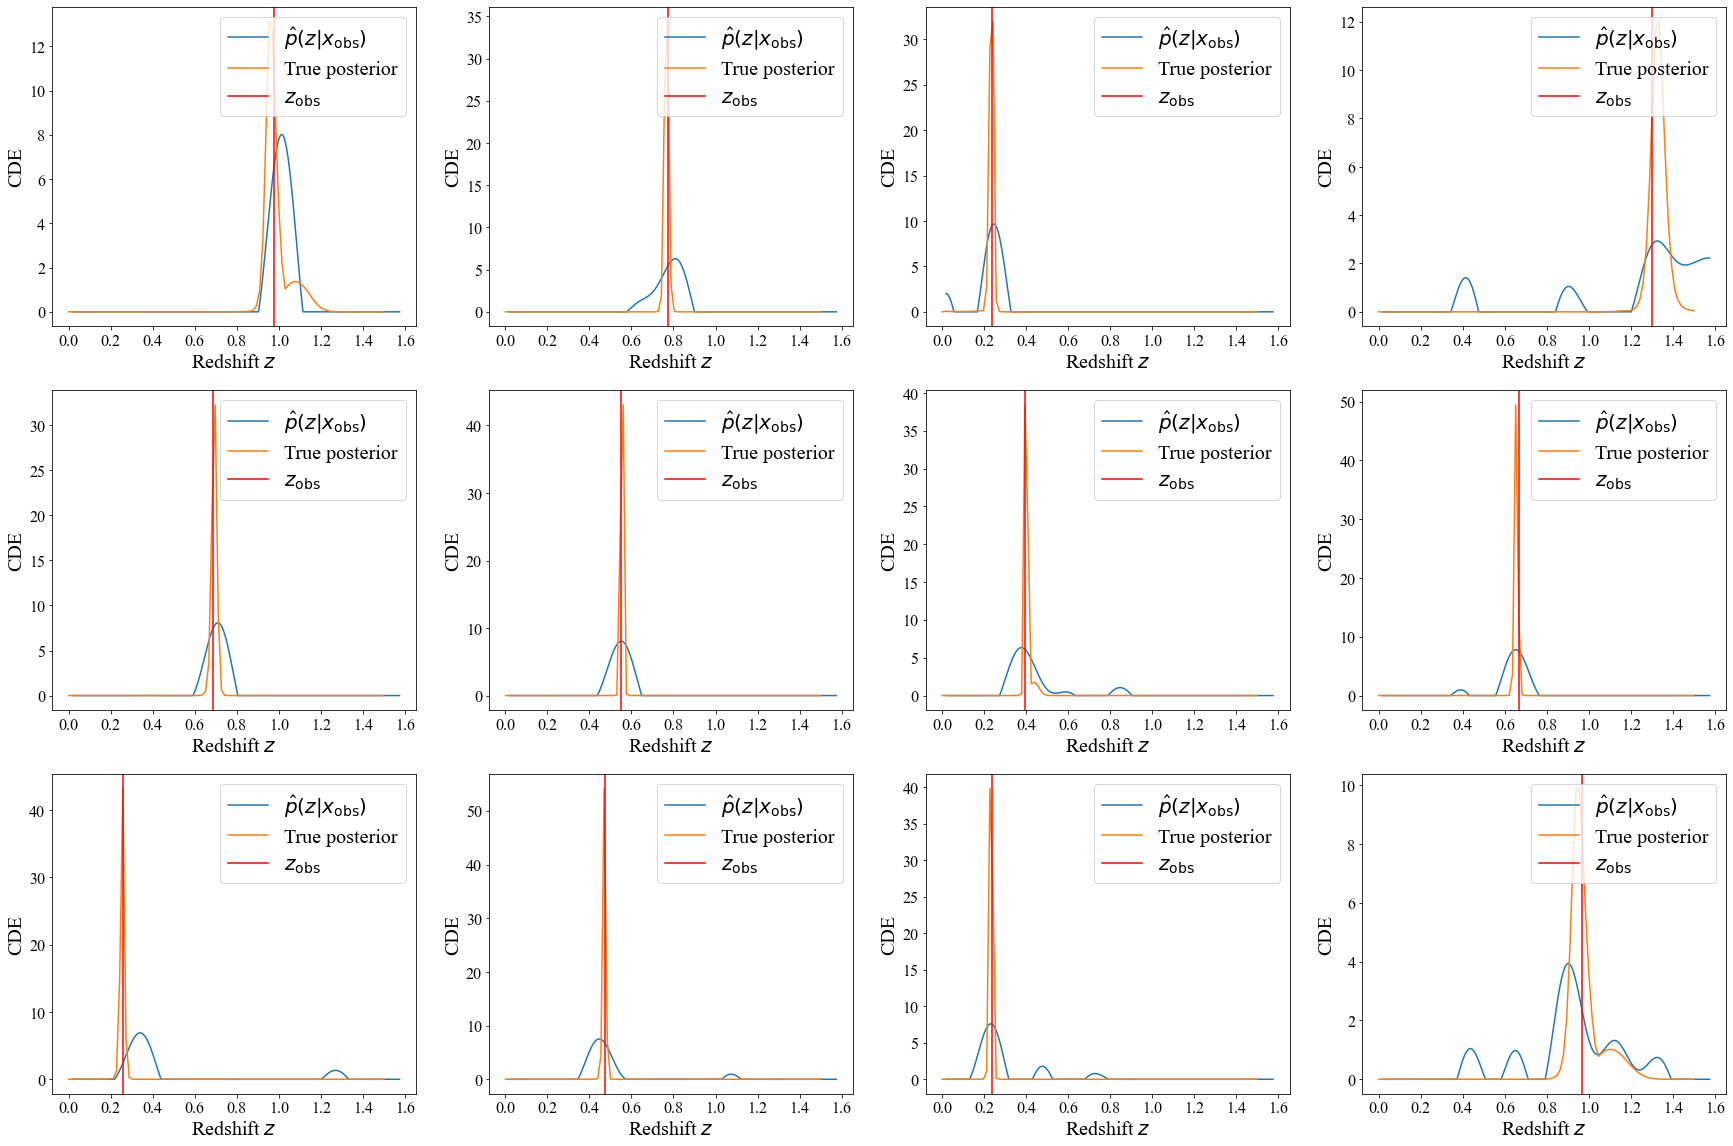

In [29]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cdes_predict_xgb[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(y_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.plot(grid, posteriors_test[jj], label='True posterior')
    plt.axvline(y_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

##### Sharpen Alpha

##### for some reason, it does not choose sharpen > 1.0

In [49]:
bump_threshold_vec = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
sharpen_vec = np.linspace(1,2,11)
model.tune(x_validation, y_validation, bump_threshold_grid=bump_threshold_vec, sharpen_grid=sharpen_vec, n_grid=n_grid)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)
print('Best Sharpen Alpha: %s' % model.sharpen_alpha)

Best Bump Removal Threshold: 0.005
Best Sharpen Alpha: 1.0


##### in fact, it chooses sharpen < 1.0

In [54]:
bump_threshold_vec = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
sharpen_vec = np.linspace(0.1,2,20)
model.tune(x_validation, y_validation, bump_threshold_grid=bump_threshold_vec, sharpen_grid=sharpen_vec, n_grid=n_grid)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)
print('Best Sharpen Alpha: %s' % model.sharpen_alpha)

Best Bump Removal Threshold: 0.005
Best Sharpen Alpha: 0.1


##### here, I hard code a sharpen of 2 to see what happens

In [55]:
bump_threshold_vec = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
sharpen_vec = [2]
model.tune(x_validation, y_validation, bump_threshold_grid=bump_threshold_vec, sharpen_grid=sharpen_vec, n_grid=n_grid)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)
print('Best Sharpen Alpha: %s' % model.sharpen_alpha)

Best Bump Removal Threshold: 0.005
Best Sharpen Alpha: 2


In [56]:
cdes_predict_xgb, y_grid = model.predict(x_test, n_grid=1000)

In [57]:
cde_loss_val, std_cde_loss = cde_loss(cdes_predict_xgb, y_grid, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -4.80 \pm 0.31


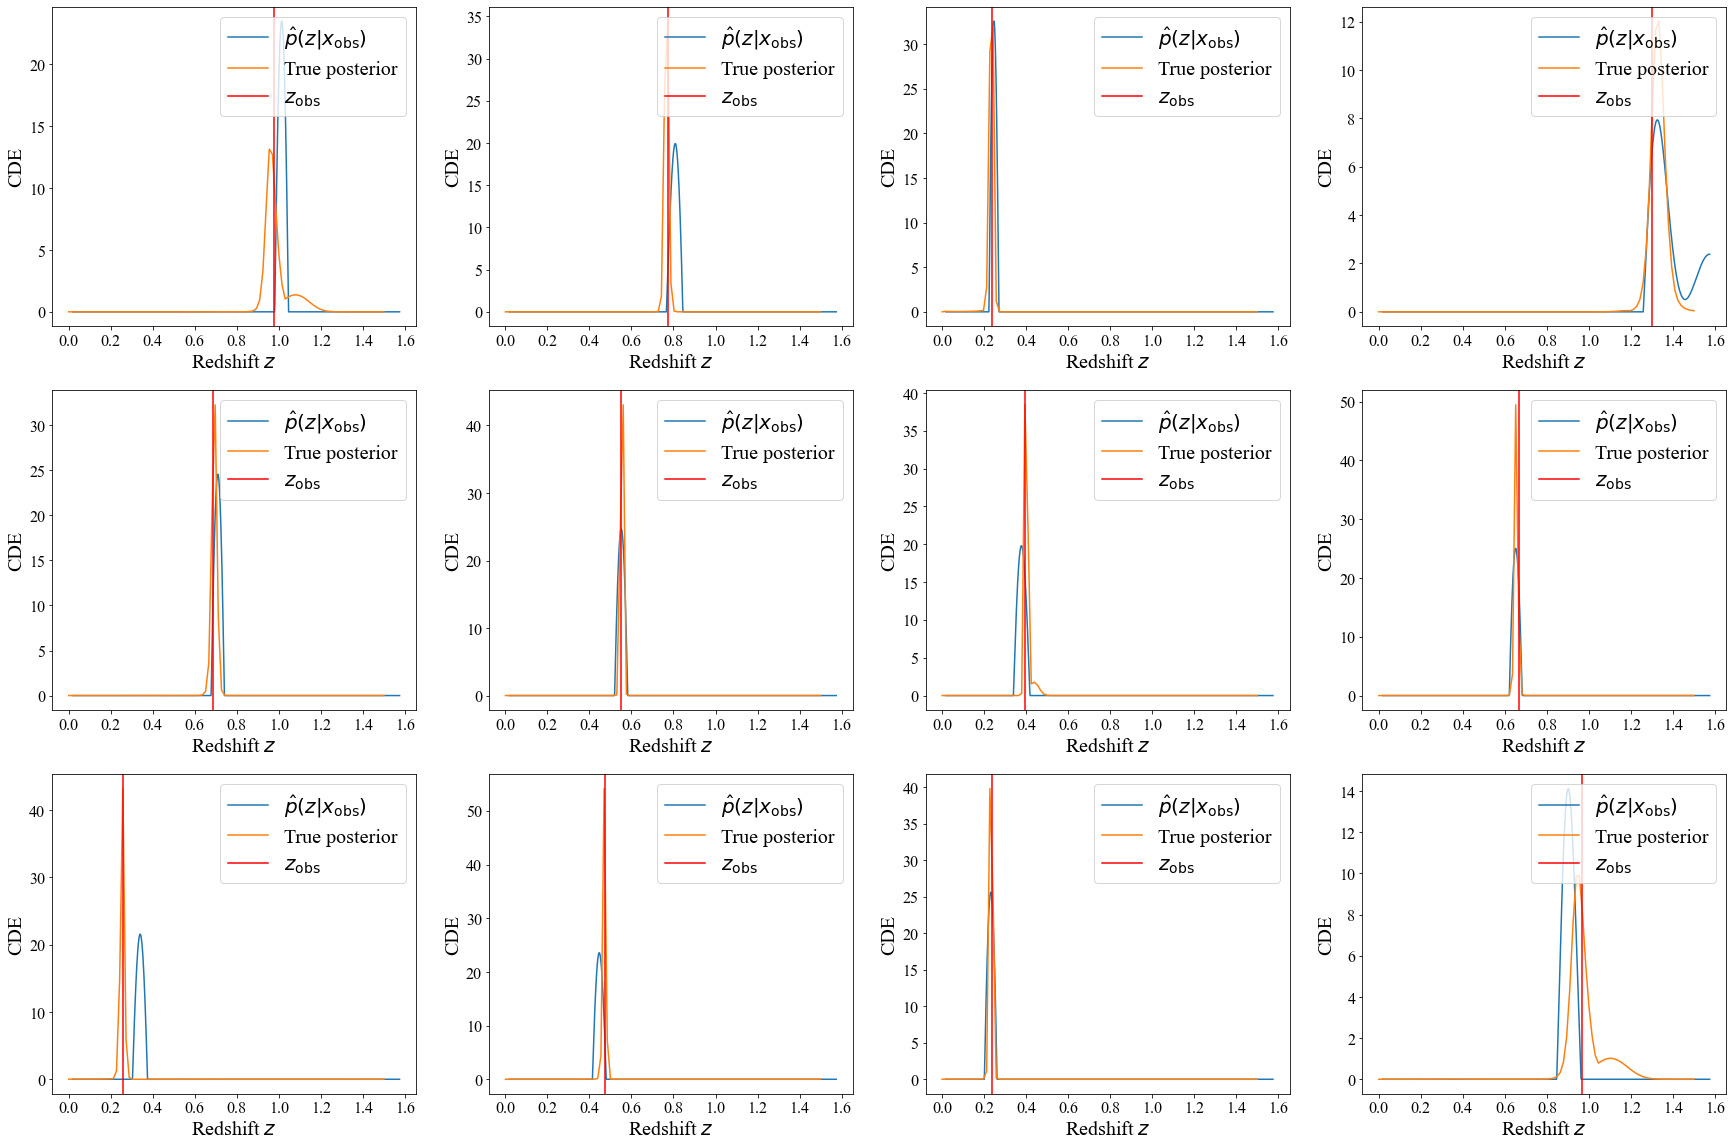

In [58]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cdes_predict_xgb[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(y_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.plot(grid, posteriors_test[jj], label='True posterior')
    plt.axvline(y_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

##### (END OF OUR NEW EXPLORATORY CODE)

We can examine one of the photo-$z$ posteriors estimated with the perfectly representative training/validation set.

In [ ]:
chosen = 9

plt.plot(y_grid, cde_test[chosen], label='Estimated posterior')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(y_test[chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

It looks pretty good!
Now let's try training and validating with some Happy/Teddy data but estimating posteriors on the test set from the pzflow demo.

In [ ]:
y_train = pd.read_csv('teddyAredshifts.csv')['redshift'].to_numpy()
x_train = pd.read_csv('teddyAphotometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()

y_validation = pd.read_csv('teddyBredshifts.csv')['redshift'].to_numpy()
x_validation = pd.read_csv('teddyBphotometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()

In [ ]:
# Parameterize model
model = flexcode.FlexCodeModel(NN, max_basis, basis_system, regression_params=params)

# Fit model - this will also choose the optimal number of neighbors `k`
model.fit(x_train, y_train)

# # # Tune model - Select the best number of basis
model.tune(x_validation, y_validation)

# # Predict new densities on grid
cde_test_bias, y_grid_bias = model.predict(x_test, n_grid=n_grid)

In [ ]:
plt.plot(y_grid_bias, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(y_test[chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

As expected, the biased training and validation sets worsen the estimated posterior PDFs.

### Your turn!

AI is underutilized in estimating photo-$z$ posteriors, so the most exciting aspect of this challenge is to improve upon existing estimators.

**CHALLENGE**: Implement another estimator of photo-$z$ posteriors; consider those used in [Brian Nord's data challenge](https://github.com/deepskies/DeeplyUncertain-Public) for inspiration.

**CHALLENGE**: Devise and implement a way to obtain likelihoods $p(\vec{d} | z, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)$ rather than posteriors $p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)$ .

## 3. Evaluating the performance of estimated photo-$z$ posterior PDFs

Once we have estimated photo-$z$ posterior PDFs, we need a way to determine if they're actually any good.
Since the tutorial has only one method but multiple training/validation sets, that's all we can compare for now.

### Metrics of estimated photo-$z$ posteriors and true redshifts

First, let's try out a couple metrics of estimated photo-$z$ posteriors that do not require knowledge of the true photo-$z$ posteriors.
There's additional functionality for the case of having true redshifts but not true posteriors in [cdetools](https://github.com/tpospisi/cdetools) and [cde-diagnostics](https://github.com/zhao-david/CDE-diagnostics), but this should give a general idea.

In [ ]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage

The Probability Integral Transform (PIT) is defined as 
\begin{equation}
PIT = \int_{-\infty}^{z_{true}} p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz .
\end{equation}
A histogram of PIT values is commonly used to assess how consistent a population of photo-$z$ PDFs are with the true redshifts.
Ideally, it would be a uniform distribution, meaning N% of galaxies have their true redshift within the Nth percentile of their estimated photo-$z$ posterior PDF.

In [ ]:
pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, y_test)
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(pit_values, alpha=0.5, bins=100, label='representative')
plt.hist(pit_values_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0, 100)
plt.legend()
plt.xlabel('PIT')

The Highest Predictive Density (HPD) 
\begin{equation}
HPD = \int_{z': p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) \geq p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)} p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz
\end{equation}
is like the area of the PDF where it exceeds a given value.
Over a population, it would ideally be flat, like the PIT.
[A talk by David Zhao (CMU)](https://drive.google.com/file/d/1uvPtK_RcTUHEwt0ZYld41VKEPHnehWbN/view) has a lovely visualization of the HPD.

In [ ]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, y_test)
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(hpd_cov, alpha=0.5, bins=100, label='representative')
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0, 100)
plt.legend()
plt.xlabel('HPD')

The CDE loss 
\begin{equation}
\hat{L} = \frac{1}{K} \sum_{i=1}^{K} \int \left(p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)\right)^{2} dz - \frac{2}{K} \sum_{i=1}^{K} p(z_{i} | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)
\end{equation}
approximates the true posterior from the estimated posterior evaluated at the true redshift.
It's explained quite well in [a talk by Nic Dalmasso (CMU)](https://www.dropbox.com/s/2r4tl4qv0iyqo9b/STAMPS_LSST_CDE_Tools_Presentation.pdf?dl=0).
A lower value indicates a better estimator.

In [ ]:
print(cde_loss.cde_loss(cde_test, y_grid, y_test))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, y_test))

### Comparison of estimated and true photo-$z$ posterior PDFs

There are two categories of metrics of approximated and true PDF: 
those that either rely upon or force the normalization condition $\int p(z) dz = 1$and those that evaluate differences between arbitrary functions.
`qp` [(Malz, et al 2018)](https://arxiv.org/abs/1806.00014) is a package for manipulating univariate PDFs under many parameterizations and includes a few comparison metrics.

The [original version](https://github.com/aimalz/qp) consistently enforced normalization but had limited functionality, whereas the [new version](https://github.com/LSSTDESC/qp) includes many more parameterizations whose usage is "at your own risk" in terms of possibly violating normalization.
We'll use the new version for the sake of speed but evaluating metrics using simplified functions ported from the old version due to a (hopefully transient) bug in the handling of large sets of posteriors.
The first step is to get both the true posteriors and the approximations evaluated on the same grid of redshifts.

_This content is adapted from the [qp demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/demo.ipynb), written by Alex Malz (GCCL@RUB), Phil Marshall (SLAC), and Eric Charles (SLAC), and [qp metrics demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/kld.ipynb), written by Alex Malz (GCCL@RUB) and Phil Marshall (SLAC)._

In [ ]:
# P = qp.Ensemble(qp.interp, data=dict(xvals=grid.reshape(grid.shape[0]), yvals=posteriors_test))
Q = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test))
Q_bias = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid_bias.shape[0]), yvals=cde_test_bias))
grid, approx_pdf_on_grid = Q.gridded(grid)
grid, approx_pdf_on_grid_bias = Q_bias.gridded(grid)

The Kullback Leibler Divergence (KLD)
\begin{equation}
KLD = \int_{-\infty}^{\infty} p(z | \vec{d}) \log\left[\frac{p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)}{p(z | \vec{d})}\right] dz
\end{equation}
is a directional measure of how much information is lost by using the estimated $p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)$ instead of the true $p(z | \vec{d})$.
We want the KLD for each galaxy to be low.

In [ ]:
KLDs = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
KLDs_bias = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(KLDs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(KLDs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('KLD')
plt.legend()
plt.semilogy()

The root-mean-square-error (RMSE) is a symmetric measure commonly used to compare 1D functions.
**TODO: write it out?** Similarly, a lower value corresponds to a more closely approximating posterior PDF.

In [ ]:
RMSEs = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
RMSEs_bias = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(RMSEs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(RMSEs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('RMSE')
plt.legend()

In [ ]:
chosen = np.argmax(RMSEs)
chosen_bias = np.argmax(RMSEs_bias)

plt.plot(y_grid_bias, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(y_test[chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

### Your turn!

These are just a few metrics; 
how else can we quantify the performance of estimators of aleatoric uncertainty?

**CHALLENGE**: Apply and visualize the local metrics of [Zhao, Dalmasso, Izbicki & Lee, 2021](https://arxiv.org/abs/2102.10473), or any other metrics not included in this demo; the [cde-diagnostics tutorial](https://github.com/zhao-david/CDE-diagnostics/blob/main/tutorial/tutorial-cde-diagnostics.ipynb), written by David Zhao (CMU), may be a good starting point.

**CHALLENGE**: Use the differences between estimated and true photo-$z$ posterior PDFs as a function of photometry to isolate the implicit prior of epistemic uncertainty from the aleatoric uncertainty.

# Your turn: How to participate in this challenge tl;dr

The organizers have identified three hack-able aspects to this data challenge:
- Quantify sensitivity of ML photo-z posterior estimators to training set non-representativity
- Implement and test additional AI methods for photo-z posterior estimation
- Implement/interpret additional metrics of posterior precision

Of course, there are many other possibilities for what to investigate based on this starting material!

To participate, clone this tutorial's [GitHub repo](https://github.com/aimalz/qtc2021), make or comment on [an issue](https://github.com/aimalz/qtc2021/issues) saying what you'd like to hack on, and work in a branch corresponding to that issue.
The only rule is that if your hack leads to a publication, you cite the repo (and, of course, invite those who contributed to your solution to be authors).